In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import linear_model
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import math
from mpl_toolkits.mplot3d import Axes3D
import random
import matplotlib.colors as mcolors
import tensorflow as tf
from tensorflow.keras import layers,models
from keras.layers import BatchNormalization, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.models import Model
from typing import Tuple, List

# ALGORITHMS:

## Kmeans and Auto clustering:
the do_clustering algorithym processes one hour data and total rainfall and replaces the hourly values with clustercenters at every turn. after processing the whole 24hours it then clusterizes the total rainfall separately for performing query on the clusterspace.
### INPUT: 
 1. dataframe: the dataset to be clusterized.
 2. hour: recursive variable.
 3. epoch: number of intersection point to be obtained.
 4. limit: maximum allowable cluster

In [ ]:
def do_clustering(data_frame,hour,epoch= 3,limit= 30):
    if hour== 25:
        scaler = MinMaxScaler()
        a=scaler.fit_transform(data_frame.iloc[:,[-1]])

        km=KMeans(n_clusters=1)
        km.fit(a)
        x_first= km.inertia_
        old_x_first= 0
    
        km=KMeans(n_clusters=limit)
        km.fit(a)
        x_last= km.inertia_
        old_x_last= 0
    
        k= 1
        flag= 1
        array= np.zeros((epoch,2),dtype= float)
        for i in range(epoch) :
            old_x_first= x_first
            old_x_last = x_last
            k = k+1
            km=KMeans(n_clusters=k)
            km.fit(a)
            x_first= km.inertia_
            km=KMeans(n_clusters=limit-(k-1))
            km.fit(a)
            x_last= km.inertia_          
            nr        = ((x_last-x_first)+(x_first-old_x_first)*k-(x_last-old_x_last)*(limit-(k-1)))
            dr        = ((x_first-old_x_first)-(x_last-old_x_last))
            array[i,0]= nr/dr
            array[i,1]= (x_first-old_x_first)*((nr/dr)-k)+x_first
        
        reg= linear_model.LinearRegression()    
        reg.fit(array[:, 0].reshape(-1, 1), array[:, 1])
    
        min_cluster= 1
        k= (min_cluster+limit)/2
        k= int(k)
        while min_cluster<limit:
            km=KMeans(n_clusters=k)
            km.fit(a)
            if reg.predict(np.array([[k]]))>km.inertia_:
                limit= k-1
            if reg.predict(np.array([[k]]))<km.inertia_:
                min_cluster= k+1
            else:
                index= k
            k= int((min_cluster+limit)/2)
        index= k
        
        km = KMeans(n_clusters=index)
        s  = km.fit_predict(a)
        q  = km.cluster_centers_
    
        data_frame['cluster']=s
        data_frame['TOTRF']=q[data_frame['cluster'],0]
        data_frame.drop(columns=['cluster'],inplace= True)
        data_frame['TOTRF']= scaler.inverse_transform(data_frame.iloc[:,[-1]])[:,0]
        
        return data_frame
    
    #plt.scatter(data_frame.iloc[:,-2],data_frame.iloc[:,-1])
    scaler = MinMaxScaler()
    a=scaler.fit_transform(data_frame.iloc[:,[-1,hour-1]])
    
    km=KMeans(n_clusters=1)
    km.fit(a)
    x_first= km.inertia_
    old_x_first= 0
    
    km=KMeans(n_clusters=limit)
    km.fit(a)
    x_last= km.inertia_
    old_x_last= 0
    
    k= 1
    flag= 1
    array= np.zeros((epoch,2),dtype= float)
    for i in range(epoch) :
        old_x_first= x_first
        old_x_last = x_last
        k = k+1
        km=KMeans(n_clusters=k)
        km.fit(a)
        x_first= km.inertia_
        km=KMeans(n_clusters=limit-(k-1))
        km.fit(a)
        x_last= km.inertia_          
        nr        = ((x_last-x_first)+(x_first-old_x_first)*k-(x_last-old_x_last)*(limit-(k-1)))
        dr        = ((x_first-old_x_first)-(x_last-old_x_last))
        array[i,0]= nr/dr
        array[i,1]= (x_first-old_x_first)*((nr/dr)-k)+x_first
        
    reg= linear_model.LinearRegression()    
    reg.fit(array[:, 0].reshape(-1, 1), array[:, 1])
    
    min_cluster= 1
    k= (min_cluster+limit)/2
    k= int(k)
    while min_cluster<limit:
        km=KMeans(n_clusters=k)
        km.fit(a)
        if reg.predict(np.array([[k]]))>km.inertia_:
            limit= k-1
        if reg.predict(np.array([[k]]))<km.inertia_:
            min_cluster= k+1
        else:
            index= k    
        k= int((min_cluster+limit)/2)
    index= k
    
    print('index for hour',hour,'is',index)
    km = KMeans(n_clusters=index)
    s  = km.fit_predict(a)
    q  = km.cluster_centers_
    data_frame['cluster']=s
    formatted_hour = str(hour).zfill(2)
    data_frame['HRF'+formatted_hour]=q[data_frame['cluster'],1]
    
    data_frame.drop(columns=['cluster'],inplace= True)
    data_frame['HRF'+formatted_hour]= scaler.inverse_transform(data_frame.iloc[:,[-1,hour-1]])[:,1]
                                                                                  
    i= int((hour-1)/2)
    j= int((hour-1)%2)
    axs[i, j].scatter(data_frame['TOTRF'],data_frame['HRF'+formatted_hour],c=s, cmap='CMRmap')
    axs[i, j].set_title('HRF'+formatted_hour)
    
    return do_clustering(data_frame,hour+1)

## Image generation and CBIR:
the selector algorithym checks for valid sequences for images(consecutive days of rainfall without any null entry for the specified amount of days) and makes image dataset and the proxy output set. Then it dploys the CNN architechture and trains it. After that the images are again parsed through the CNN to construct the signature dataset which is later used for accessing similarity during predection. Although not of primary importance but it plots the relevent metrices for CNN.

### INPUT:
 1. df: the dataframe of interest.
 2. days: no of consecutive days.
 3. layered set: the set of generated images.

In [ ]:
def selector(df,days= 10):
    indices_to_drop = []
    for index, row in df.iterrows():
        if row.isnull().any():
            for i in range(days):
                idx = index - i
                if idx in df.index:
                    indices_to_drop.append(idx)

    df.drop(indices_to_drop, inplace=True)
    df = df.reset_index(drop=True)
    
    
    df_train= df.drop(columns= ['MN','Season'])
    df_test = df['Season']
    image_set= df_train.values
    num_images = image_set.shape[0]-(days-1)
    height = days
    width = image_set.shape[1]
    layered_set = np.zeros((num_images,height,width),dtype= float)
    for i in range(num_images):
        layered_set[i,:,:]= image_set[i:(i+days),:]
    layered_set= layered_set.reshape(layered_set.shape[0],layered_set.shape[1],layered_set.shape[2],1)

    final_level= df_test.values
    final_level= final_level[(days-1):]
    final_level= final_level.astype(int)
    final_level= final_level.reshape(-1,1)
    del image_set
    
    ohe= OneHotEncoder()
    final_level= ohe.fit_transform(final_level).toarray()
    X_train, X_test, y_train, y_test = train_test_split(layered_set, final_level, test_size=0.2, random_state=42)
    
    model = models.Sequential()
    model.add(layers.Conv2D(32, kernel_size=(1,5), activation='relu', input_shape=(layered_set.shape[1],layered_set.shape[2],layered_set.shape[3])))
    model.add(layers.Conv2D(32, kernel_size=(1,10), activation='relu',padding= 'same'))
    model.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu',padding= 'same'))
    model.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu',padding= 'same'))
    model.add(layers.Conv2D(8, kernel_size=(days,5), activation='relu',padding= 'same'))
    model.add(layers.Flatten(name= 'flatten'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.25)) 
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(4, activation='softmax'))  
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train,y_train, epochs=50, batch_size=64, validation_split=0.2)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(model.history.history['accuracy'])
    plt.plot(model.history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    
    print(model.summary())
    flatten_output_model= Model(inputs=model.inputs, outputs=model.get_layer('flatten').output)
    
    return flatten_output_model.predict(layered_set),model

## Redistribution Mechanism:
This algorithm takes one day rainfall data distributed across hours and balances out the excess or the deficit that might have been there due to the generalization of data in clusterspace through cluster centers.

### INPUT:

1. input: the series that is to be balanced out.
2. reference: the dataset with respect to whome the feasibility of the target series will be evaluated after every iteration.
3. trf: the actual rainfall.
4. epoch: number of times this iteration happens.
5. alpha: learning rate.

In [ ]:
def mse(array: np.ndarray, value: float) -> float:
    return (np.sum(array)- value)**2

def seasonal_line(array: np.ndarray, reference: pd.DataFrame) -> Tuple[float, np.ndarray]:
    a = reference.values
    b = np.tile(array, (a.shape[0], 1))
    dot_products = np.sum(a * b, axis=1)
    norms_a = np.linalg.norm(a, axis=1)
    norms_b = np.linalg.norm(b, axis=1)
    cosine_similarities = dot_products / (norms_a * norms_b)
    cosine_similarities = np.nan_to_num(cosine_similarities, nan=0.0)
    fs = np.max(cosine_similarities)
    p = a[np.argmax(cosine_similarities)]
    p_mod = norms_a[np.argmax(cosine_similarities)]
    v_mod = norms_b[np.argmax(cosine_similarities)]
    del_fs = (p / p_mod * v_mod) - (fs * array)
    return fs, del_fs

def forward_pass(input_: np.ndarray, weights: np.ndarray, reference: pd.DataFrame, trf: float) -> Tuple[np.ndarray, float, np.ndarray, np.ndarray, float]:
    op_1 = input_ * weights
    fs, del_fs = seasonal_line(op_1, reference)
    op_2 = np.abs(op_1 * fs)
    error = mse(op_2, trf)
    return op_1, fs, del_fs, op_2, error

def backward_pass(input_: np.ndarray, op_1: np.ndarray, fs: float, del_fs: np.ndarray, op_2: np.ndarray, error: float) -> np.ndarray:
    del_wt = (2 * np.sqrt(error) * (fs + (np.sum(op_1) * del_fs))) * input_
    return del_wt

def parameter_upgrade(weights: np.ndarray, del_wt: np.ndarray, op_2: np.ndarray, trf: float, alpha: float) -> np.ndarray:
    if (np.sum(op_2) - trf) > 0:
        weights = weights - alpha * del_wt
    else:
        weights = weights + alpha * del_wt
    return weights

def Bias_correction(input_: np.ndarray, reference: pd.DataFrame, trf: float, epochs: int = 50, alpha: float = 0.08) -> np.ndarray:
    weights = np.ones_like(input_)
    
    for i in range(epochs):
        op_1, fs, del_fs, op_2, error = forward_pass(input_, weights, reference, trf)
        del_wt = backward_pass(input_, op_1, fs, del_fs, op_2, error)
        weights = parameter_upgrade(weights, del_wt, op_2, trf, alpha)
    
    return op_2

# MODEL CALIBRATION:
given below is an image of a typical training dataset.

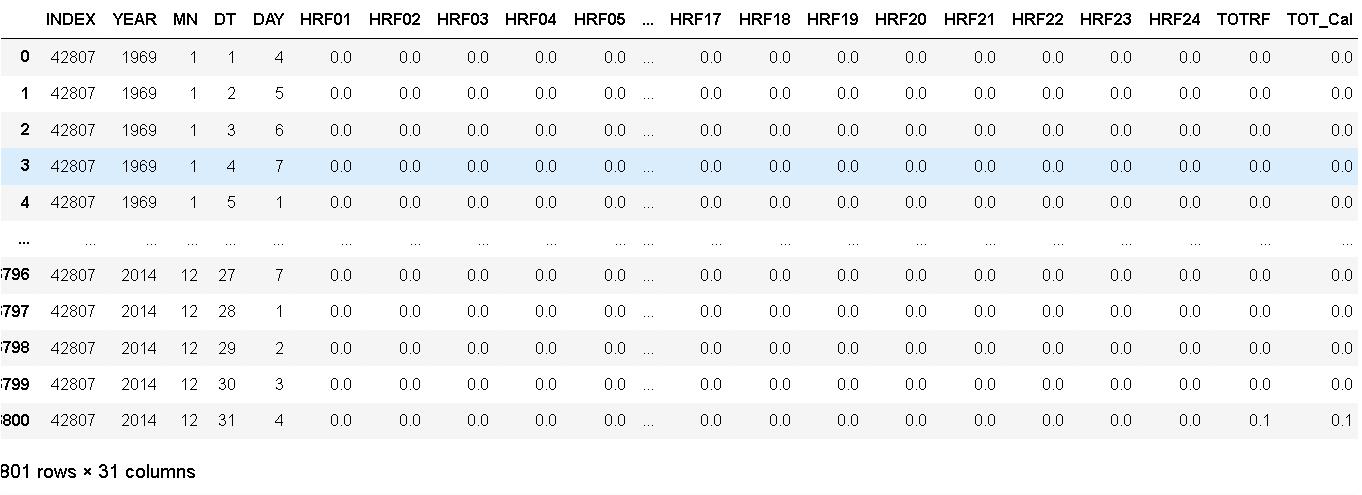

## Input and processing for clusterspace

In [ ]:
# Taking INPUT:
rainfall_data = pd.read_csv('Train_.csv') 
#_________________________________________________________________________________#

# Dropping the columns and NULL values for clustering:
df = rainfall_data.drop(columns=['INDEX', 'YEAR', 'MN', 'DT', 'DAY', 'TOT_Cal'])
df.dropna(inplace=True)
#_________________________________________________________________________________#

#Inserting Seasonal information:
season_mapping = {
    1: 1, 2: 1, 3: 2,
    4: 2, 5: 2, 6: 3,
    7: 3, 8: 3, 9: 3,
    10: 4, 11: 4, 12: 4
}
rainfall_data['Season'] = rainfall_data['MN'].map(season_mapping)
#_________________________________________________________________________________#

#ClusterSpace and plot:

#1. eleminating 0 values from clusterspace-
df = df[df['TOTRF'] != 0]

#2. defining figure and plot area-
fig, axs = plt.subplots(12, 2, figsize=(15, 90))

#3. implementing clusterspace-
cluster_data = do_clustering(df,1)

#4. Inserting season information in clusterspace(i.e.clusterdata):
a = rainfall_data[rainfall_data['TOTRF'] != 0]['Season']
cluster_data['Season'] = a
cluster_data.reset_index(drop=True, inplace=True)

#5. Plotting the clusters:
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.tight_layout()
plt.show()
#___________________________________________________________________________________#

## Preparing the CBIR mechanism:

In [ ]:
# Dropping unnecessary information wrt cbir: 
df_2 = rainfall_data.drop(['INDEX','YEAR','TOT_Cal','DT','DAY'], axis=1)
#___________________________________________________________________________#

# Calling selector:
signature,model = selector(df_2)
#___________________________________________________________________________#

## Preparing padding
it is obtained by explicitly defining the number of days to be extracted as padding which will also be the first image the cnn processes while predection and thus starting the predection.

### Variables:
 1. days: number of days which depends on the size of our generated image.
 2. i: iterates through every year to get a valid padding data(consecutive non null data entries as specified in the number of days ,e.g. here days=10;can be considered as padding data).
 3. month: the month just after which we want our predection to start.(e.g. here month= december for kolkata as the predection starts from january).
 4. flag: checks weather valid padding obtained or not.

In [ ]:
#Defining number of days and month:
days = 10
month= 12
#_________________________________________________________________________________#

#Padding:
i=0
flag= 0
while (i < len(rainfall_data['YEAR'].unique()))&(flag==0):
    df_1 = rainfall_data[(rainfall_data['YEAR'] == rainfall_data['YEAR'].unique()[i]) & (rainfall_data['MN'] == month)]
    if df_1.isnull().any().any():
        i = i + 1
    else:
        df_1.drop(columns=['INDEX', 'YEAR', 'MN','TOT_Cal','DT','DAY','Season'],inplace= True)
        initial_pad = df_1.values
        flag= 1
padding= initial_pad[-days:,:]
print('PADDING is obtained')
print('The shape of padding is:',padding.shape)

# MODEL TESTING:
given below is an image of a typical dataset provided during predection. 

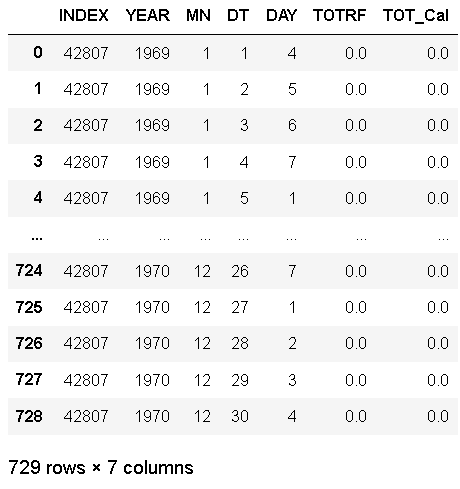

## Taking input for predection and preparing for predection:

In [ ]:
# Reading output file:
total_data = pd.read_csv('Test_.csv')
#___________________________________________________________________________________#

# Integrating season in total data:
season_mapping = {
    1: 1, 2: 1, 3: 2,
    4: 2, 5: 2, 6: 3,
    7: 3, 8: 3, 9: 3,
    10: 4, 11: 4, 12: 4
}
total_data['Season'] = total_data['MN'].map(season_mapping)
#___________________________________________________________________________________#

# Preparing for predection:

#1. Dropping unnecessary columns:
df= total_data.drop(total_data.columns.difference(['TOTRF', 'Season']), axis=1)

#2. Identifying and modifying NULL values:
df['modified']= np.zeros((len(df),1),dtype=float)
a= df['TOTRF'].values
b= df['modified'].values
for i in range(a.shape[0]):
    if np.isnan(a[i]):
        a[i]= np.mean(a[i-days:i-1])
        b[i]= 1
        
input_frame= df
#__________________________________________________________________________________#

In [ ]:
analysis_data = pd.read_csv('Analysis_Mumbai.csv')

## Iterator/Predection block:
this algorithm takes the prepared input dataset and padding and keeps on appending the predected data on padding data.

In [ ]:
for index, row in input_frame.iterrows():
    print('_______________________________________________________________________________________________________')
    print('Day:',index+1) #the day
    if row['TOTRF']==0:
        padding = np.append(padding, np.zeros((1,25),dtype=float),axis=0) # if total rainfall= 0 ; simply append 0 row to padding.
    else:    
        trf = row['TOTRF']
        season = row['Season']
        print("total_rainfall:",trf)
        print("season:",season)
        
        # query algorithm:
        
        array = cluster_data[cluster_data['Season']==season] # Filter out the seasonal data from clusterspace.
        array.reset_index(drop=True, inplace=True)           
        a = (array['TOTRF'] - trf) ** 2 #--------------------- Performing Eucledian similarity with seasonal data stored in array.                            
        array = array.iloc[a[a == a.min()].index] #----------- Fetching the most similar data from array and storing into array.
        array.drop(columns=['TOTRF','Season'], inplace=True)   
        array['TOTRF'] = np.sum(array.values[:, :], axis=1)  # Replacing the generalized total rainfall with actual total clustercenter sum
        #______________________________________________________________________________#
        
        # re-distribution:
        
        bias_corrected = np.zeros((len(array), 25), dtype=float) # This bias_corrected array will contain the redistributed rainfall values.
        reference = array.copy(deep= True) #---------------------- array itself works as a good reference as similarity and seasonality is there.
        scalar    = reference.max().max()  #---------------------- Getting the scaling value too scale reference from 0 to 1.
        reference = reference/scalar       #---------------------- Scaling the whole reference dataset.
        scaled_trf= trf/scalar             #---------------------- Scaling total rainfall.
        reference.drop(columns=['TOTRF'], inplace=True) #--------- Removing total rainfall column from reference.
        for i in range(len(reference)):
            if abs(array.iloc[i, -1] - trf) > 2.5: #-------------- Deploying Redistribution mechanism for significant difference.
                output = np.zeros((1, 24))
                output = Bias_correction(reference.iloc[i,:].values,reference,scaled_trf) #The redistributed output is being stored in output array.
                output = np.append(output, np.sum(output)) #------ Calculating total rainfall.
                output= output*(trf/output[-1]) #----------------- Scaling the output back to original scale.
                bias_corrected[i, :] = output   #----------------- The output being stored in bias_corrected array.
            else:
                bias_corrected[i, :] = array.values[i, :] #------- For small deviations the array  value is getting stored in bias_corrected.
        #________________________________________________________________________________#
        
        #image preparation:
        
        p = padding[-(days - 1):, :] # ---------- Last (days-1) rows from padding.
        image = np.zeros((1, days, p.shape[1])) 
        image[0,:-1,:] = p[:,:] #---------------- Forming the image.
        flatten_output_model = Model(inputs=model.inputs, outputs=model.get_layer('flatten').output) # defining the signature extraction.
        likelihood = []
        #________________________________________________________________________________#
        
        # Content based image retrival:
        
        #1. Prepare a batch of images: each one with bias_corrected[i] in the last row:
        #Instead of forming one image at a time the whole bias_corrected array is being converted. 
        img_stack = np.zeros((bias_corrected.shape[0], days, p.shape[1]), dtype=np.float32)
        for i in range(bias_corrected.shape[0]):
            img_stack[i, :-1, :] = p
            img_stack[i, -1, :] = bias_corrected[i, :] 
            
        #2. Setting the CNN up:
        # defining the signature extraction.
        flatten_output_model = Model(inputs=model.inputs, outputs=model.get_layer('flatten').output)
        
        #3. Convert batch to tensor and run CNN flatten layer in one go:
        # The image stack is being processed 64 at a time for signature.
        img_tensor = tf.convert_to_tensor(img_stack, dtype=tf.float32)
        f_vecs = flatten_output_model.predict(img_tensor, batch_size=64) 
        
        #4. Convert CNN encodings and signature to tensors:
        f_tensor = tf.convert_to_tensor(f_vecs, dtype=tf.float32)
        sig_tensor = tf.convert_to_tensor(signature, dtype=tf.float32)
        
        #5. Cosine similarity across all feature vectors (GPU):
        dot = tf.matmul(f_tensor, tf.transpose(sig_tensor))  # [batch, sig_bank]
        norm_f = tf.norm(f_tensor, axis=1, keepdims=True)
        norm_sig = tf.norm(sig_tensor, axis=1, keepdims=True)
        norm_matrix = tf.matmul(norm_f, tf.transpose(norm_sig)) + 1e-8
        cos_sim = dot / norm_matrix  # cosine similarity matrix
        
        #6. Get max similarity score for each candidate:
        likelihood = tf.reduce_max(cos_sim, axis=1).numpy()
        
        #7. Choose the candidate with highest similarity:
        final = bias_corrected[np.argmax(likelihood)]
        #__________________________________________________________________________________#
        
        #Appending the predected data in padding:
        padding = np.append(padding,final.reshape(1,-1),axis=0)
        
        plt.plot(range(24), final[:24], label="Prediction")
        plt.plot(range(24), analysis_data.iloc[index, 5:29], label="Ground Truth")
        print("25th Predicted:", final[24])
        print("25th True:", analysis_data.iloc[index, 29])

        plt.legend()
        plt.show()
        # deleting locals:
        if 'output' in locals():
            del output
        del array,image,p,bias_corrected,likelihood,reference,final

In [ ]:
padding.shape

## Post Processing:

 1. Removes any extra information from data.
 2. merge the predected data with the input provided during predection.
 3. filters out negligible rainfall values.
 4. Exports the produced dataframe as an Excel file.

In [ ]:
#1. Remove 'Season' Column if it exists:
if 'Season' in rainfall_data.columns:
    rainfall_data.drop(columns=['Season'], inplace=True)
if 'Season' in total_data.columns:
    total_data.drop(columns=['Season'], inplace=True)
#___________________________________________________________________________________________#

#2. Extract output:
output = padding[days:, :]
#___________________________________________________________________________________________#

#3. Merging the predected data with provided data:
a = total_data.iloc[:output.shape[0], :]
meta = a[['INDEX', 'YEAR', 'MN', 'DT', 'DAY']].values         
tot_cal = a[['TOT_Cal']].values                                
final_output = np.hstack((meta, output, tot_cal))
#___________________________________________________________________________________________#

#4. Creating dataframe:
output_df = pd.DataFrame(final_output, columns=rainfall_data.columns)
#____________________________________________________________________________________________#

#5. Apply Threshold
output_df = output_df.applymap(lambda x: 0 if x < 0.3 else x)
#____________________________________________________________________________________________#

#6. Reintroducing Null values:
b = input_frame.iloc[:output.shape[0], :]
nan_mask = b['modified'] == 1
output_df.loc[nan_mask, 'TOTRF'] = np.nan
#___________________________________________________________________________________________#

#7. Export to Excel:
output_df.to_csv('C:\\Users\\swaga\\OneDrive\\Desktop\\Output_.csv', index=False)
#___________________________________________________________________________________________#